In [2]:
import tifffile
import euler_gpu
import os, random
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
from tqdm import tqdm
from math import pi as PI
from math import tau as TAU 
device = torch.device("cuda:0")
BATCH_SIZE = 256

In [3]:
tiff_folder = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250212124023_RFa_noswim"
files = [f for f in os.listdir(tiff_folder) if f.endswith(".tif") or f.endswith(".tiff")]
files = sorted(files, key = lambda x: int(x.split("_")[-1].split("-")[0]))
print(files)

red_channel = 1
fixed_frame = 0

## If you need to use channel alignment, uncomment the following line
# files = ["CHAN_" + f for f in files]


['20250212_Experiment_01_0-1999.tif', '20250212_Experiment_01_2000-3999.tif', '20250212_Experiment_01_4000-5999.tif', '20250212_Experiment_01_6000-7999.tif', '20250212_Experiment_01_8000-9999.tif']


In [4]:
inputs = tifffile.imread(os.path.join(tiff_folder, files[0]))

: 

: 

In [ ]:
TH_CONST = np.array([0])
XY_RANGE_STEP1 = np.concatenate((np.linspace(-0.5, 0.5, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.1, 0.1, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.01, 0.01, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .17, 20, dtype=np.float32), np.linspace(3, 3.141592, 20, dtype=np.float32), TH_CONST))
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .17, 10, dtype=np.float32), np.linspace(3, 3.141592, 10, dtype=np.float32), TH_CONST))
ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .5, 10, dtype=np.float32), np.linspace(359.5, 360, 10, dtype=np.float32), TH_CONST))

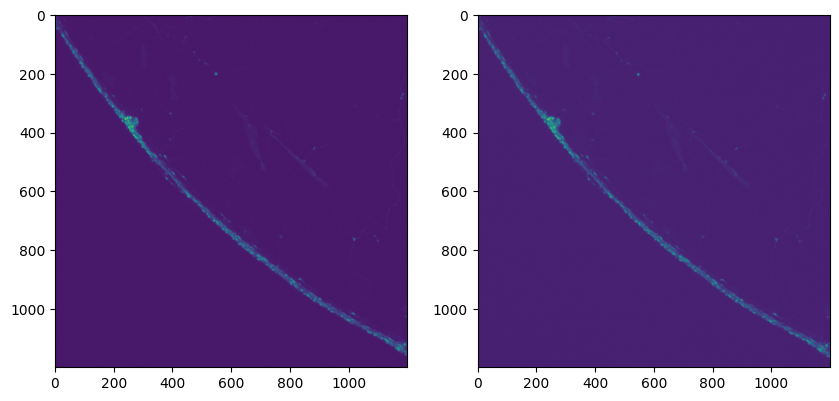

In [ ]:
moving_frame = 850

red = inputs[:, red_channel]
red = np.sqrt(red - np.min(red))
fixed_image = red[fixed_frame]
moving_image = red[moving_frame]

fig, ax = plt.subplots(1,2, figsize=(10,20))
ax[0].imshow(fixed_image)
ax[1].imshow(moving_image)

In [ ]:
memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP1, XY_RANGE_STEP1, TH_CONST, BATCH_SIZE, device)
best_score, best_transformation = euler_gpu.grid_search(memory_dict)
print(best_transformation)

align_x_range_2 = np.add(XY_RANGE_STEP2, best_transformation[0].cpu().numpy())
align_y_range_2 = np.add(XY_RANGE_STEP2, best_transformation[1].cpu().numpy())
memory_dict = euler_gpu.initialize(fixed_image, moving_image, align_x_range_2, align_y_range_2, ALIGN_TH_RANGE, BATCH_SIZE, device)
best_score, best_transformation = euler_gpu.grid_search(memory_dict)
print(best_transformation)


(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))
(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'), tensor([0.0008], device='cuda:0'))


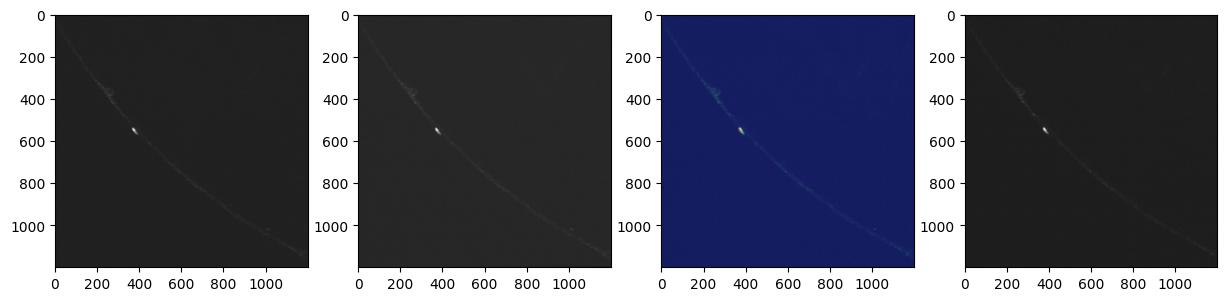

In [ ]:
in_img = torch.Tensor(moving_image[np.newaxis, np.newaxis, ...]).to(device=device)
moving_image_transformed = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict)

fig, ax = plt.subplots(1,4, figsize=(15,30))
ax[0].imshow(moving_image, cmap='gray')
ax[1].imshow(moving_image_transformed.cpu().numpy()[0,0], cmap='gray')
ax[2].imshow(fixed_image, cmap='gray')
ax[2].imshow(moving_image_transformed.cpu().numpy()[0,0], alpha = 0.3, cmap = "jet")
ax[3].imshow(fixed_image, cmap='gray')

## Align Video by adjacent frames over multiple files

In [ ]:
## Align Video by adjacent frames
other_chan = (red_channel - 1) % inputs.shape[1]

# fixed_image = red[0]
# moving_image = red[0]
fixed_image = inputs[0, red_channel]
# # moving_image = inputs[0, red_channel]
# memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP1, XY_RANGE_STEP1, ALIGN_TH_RANGE, BATCH_SIZE, device)
# best_score, best_transformation = euler_gpu.grid_search(memory_dict)
# prev_transform = best_transformation

prev_transform = (torch.tensor([0.0], device='cuda:0'), torch.tensor([0.0], device='cuda:0'), torch.tensor([0.0], device='cuda:0'))
# prev_transform = (torch.tensor([0.0244], device='cuda:0'), torch.tensor([-0.0378], device='cuda:0'), torch.tensor([0.0007], device='cuda:0'))

for file in files:
    if file == files[0]:
        ins = inputs
    else:
        ins = tifffile.imread(os.path.join(tiff_folder, file))

    out = np.empty_like(ins)
    for frame in tqdm(range(ins.shape[0])):
    # for frame in range(red.shape[0]):
        moving_image = ins[frame, red_channel]

        align_x_range_2 = np.add(XY_RANGE_STEP2, prev_transform[0].cpu().numpy())
        align_y_range_2 = np.add(XY_RANGE_STEP2, prev_transform[1].cpu().numpy())
        align_the_range = np.mod(np.add(ALIGN_TH_RANGE, (prev_transform[2].cpu().numpy() * 180) / PI), 360)
        memory_dict = euler_gpu.initialize(fixed_image, moving_image, align_x_range_2, align_y_range_2, align_the_range, BATCH_SIZE, device)
        best_score, best_transformation = euler_gpu.grid_search(memory_dict)
        
        # in_img = ins[frame, red_channel]
        in_img = torch.Tensor(moving_image[np.newaxis, np.newaxis, ...]).to(device=device)
        out[frame, red_channel] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
        in_img = ins[frame, other_chan]
        in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
        out[frame, other_chan] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
        # print(best_transformation)

        prev_transform = best_transformation
    print(prev_transform)
    tifffile.imwrite(os.path.join(tiff_folder, "RIG_" + file), out, imagej=True, bigtiff=True)



100%|██████████| 2000/2000 [40:43<00:00,  1.22s/it]


(tensor([0.0100], device='cuda:0'), tensor([-0.0111], device='cuda:0'), tensor([0.0019], device='cuda:0'))


100%|██████████| 2000/2000 [41:25<00:00,  1.24s/it]


(tensor([0.0156], device='cuda:0'), tensor([-0.0211], device='cuda:0'), tensor([0.0019], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_20240930_2000-3999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:38<00:00,  1.22s/it]


(tensor([0.0189], device='cuda:0'), tensor([-0.0289], device='cuda:0'), tensor([0.0039], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_20240930_4000-5999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [41:26<00:00,  1.24s/it]


(tensor([0.0233], device='cuda:0'), tensor([-0.0344], device='cuda:0'), tensor([0.0039], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_20240930_6000-7999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:28<00:00,  1.21s/it]


(tensor([0.0244], device='cuda:0'), tensor([-0.0389], device='cuda:0'), tensor([0.0049], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_20240930_8000-9999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:23<00:00,  1.21s/it]


(tensor([0.0300], device='cuda:0'), tensor([-0.0522], device='cuda:0'), tensor([0.0049], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_10000-11999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:28<00:00,  1.21s/it]


(tensor([0.0344], device='cuda:0'), tensor([-0.0611], device='cuda:0'), tensor([0.0020], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_12000-13999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:29<00:00,  1.21s/it]


(tensor([0.0367], device='cuda:0'), tensor([-0.0711], device='cuda:0'), tensor([0.0020], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_14000-15999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:34<00:00,  1.22s/it]


(tensor([0.0333], device='cuda:0'), tensor([-0.0811], device='cuda:0'), tensor([5.2671e-05], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_16000-17999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [41:10<00:00,  1.24s/it]


(tensor([0.0411], device='cuda:0'), tensor([-0.0989], device='cuda:0'), tensor([0.0010], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_18000-19999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:25<00:00,  1.21s/it]


(tensor([0.0633], device='cuda:0'), tensor([-0.1033], device='cuda:0'), tensor([6.0779e-05], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_20000-21999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [41:33<00:00,  1.25s/it]


(tensor([0.0889], device='cuda:0'), tensor([-0.1178], device='cuda:0'), tensor([6.2784], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_22000-23999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [41:21<00:00,  1.24s/it]


(tensor([0.0922], device='cuda:0'), tensor([-0.1189], device='cuda:0'), tensor([6.2764], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_24000-25999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [41:51<00:00,  1.26s/it]


(tensor([0.0989], device='cuda:0'), tensor([-0.1233], device='cuda:0'), tensor([6.2726], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_26000-27999.tif'> truncating ImageJ file
  warnings.warn(
100%|██████████| 2000/2000 [40:48<00:00,  1.22s/it]


(tensor([0.0989], device='cuda:0'), tensor([-0.1233], device='cuda:0'), tensor([6.2726], device='cuda:0'))


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'RIG_CHAN_202409…_28000-29999.tif'> truncating ImageJ file
  warnings.warn(
